In [1]:
import math
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import clusterer, plotting, Density

#%matplotlib inlin
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = "C:/Users/ivart/OneDrive/Bureaublad/Afstuderen/WRR/PyRICE Ivar Tjallingii/PyRICE2020/6_Uncertainty Analysis/server/model_server"
print(pydice_folder)
sys.path.append(pydice_folder)

from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)

from PyRICE_V8_long_term_uncertainty import PyRICE

from matplotlib import pyplot

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


C:/Users/ivart/OneDrive/Bureaublad/Afstuderen/WRR/PyRICE Ivar Tjallingii/PyRICE2020/6_Uncertainty Analysis/server/model_server


## Get results from uncertainty analysis 50k runs over 29 scenarios

In [2]:
from model_outcomes_uncertainty_v2 import get_all_model_outcomes_uncertainty_search

In [3]:
timepoints_to_save = np.arange(2005,2305+20,20)
objectives_list_name = ['Intertemporal utility GINI','Intertemporal impact GINI','Total Aggregated Utility','Regions below treshold']

objectives_list_timeseries_name = ['Damages ','Utility ',
            'Lowest income per capita ','Highest climate impact per capita ',
            'Distance to treshold ','Population under treshold ',
            'Intratemporal utility GINI ','Intratemporal impact GINI ',
            'Atmospheric Temperature ', 'Industrial Emission ', 'Total Output ']

supplementary_list_timeseries_name = ['CPC ','Population ']
supplementary_list_quintile_name = ['CPC pre damage ','CPC post damage ']

outcomes_names_time_series = []
for name in objectives_list_timeseries_name:
    for year in timepoints_to_save:
        name_year = name + str(year)
        outcomes_names_time_series.append(name_year)

outcomes_name_single = []
outcomes_name_multiple= []
for name in objectives_list_name:
    if name == "Regions below treshold":
        outcomes_name_multiple.append(name)
    else:
        outcomes_name_single.append(name)

outcome_name_supplementary =[]
for name in supplementary_list_timeseries_name:
    for year in timepoints_to_save:
        name_year = name + str(year)
        outcome_name_supplementary.append(name_year)
        
outcome_name_supplementary_quintile=[]
for name in supplementary_list_quintile_name:
    for year in timepoints_to_save:
        name_year = name + str(year)
        outcome_name_supplementary_quintile.append(name_year)
        

In [4]:
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
    "Latin America","OHI","Other non-OECD Asia"]

"""
####################### Population PARAMETERS and set up dataframe format #######################
"""

#get population growth rates for each region
a=[]
for i in range(31):  
    if i == 0:
        a.append("region")
    k = 2005 + 10 * i
    k = str(k)
    a.append(k)    

region_pop_gr = RICE_POP_gr.iloc[10:22,3:35]
region_pop_gr.columns =  a
region_pop_gr = region_pop_gr.set_index('region') 


In [5]:
all_policies = pd.read_csv("example_policys_principles.csv",index_col=0)

principles_list =["utilitarian","prioritarian","egalitarian","sufficitarian","nordhaus"]

total_policy_list = []

for principle in principles_list:
    policies = all_policies[all_policies['principle']==principle]
    policies = policies.dropna(axis='columns')
    policies = policies.iloc[:,:-1]
    policy_list_principle = []

    #get list of policies as input for uncertainty sampling
    for i in range(0,len(policies)):
        policy_dict = policies.iloc[i].to_dict()
        policy_list_principle.append(Policy(policies.index[i], **policy_dict)) 
    total_policy_list.append(policy_list_principle)
total_policy_list[4]

[Policy({'sr': 0.248, 'irstp': 0.015, 'miu_period': 13.0})]

In [6]:
experiments_total = pd.read_csv("long_term_uncertainty_experiments_total_complete.csv")

In [7]:
experiments_total['policy_recoded']=experiments_total['principle'].astype(str).str[0:4] + "_"+ experiments_total['policy'] 

In [ ]:
#POP_total = pd.read_csv("long_term_POP_per_time_period.csv")

In [ ]:
#CPC_total = pd.read_csv("long_term_CPC_per_time_period.csv")

In [ ]:
#CPC_total_after = pd.read_csv('long_term_CPC_after_damages_per_time_period.csv')

# Utilitarian objective analysis

In [11]:
rc1 = {'font.size': 20,
     'axes.labelsize': 20,
     'axes.titlesize': 20,
     'xtick.labelsize': 20,
     'ytick.labelsize': 20,
     'legend.fontsize': 14,
     'axes.linewidth': 1.25,
     'grid.linewidth': 1.0,
     'lines.linewidth': 1.5,
     'lines.markersize': 6.0,
     'patch.linewidth': 1.0,
     'xtick.major.width': 1.25,
     'ytick.major.width': 1.25,
     'xtick.minor.width': 1.0,
     'ytick.minor.width': 1.0,
     'xtick.major.size': 6.0,
     'ytick.major.size': 6.0,
     'xtick.minor.size': 4.0,
     'ytick.minor.size': 4.0,
     'legend.title_fontsize': 16}

sns.set(rc=rc1)

In [8]:

mapping = {0:"Not possible",1: "Possible"}
experiments_total = experiments_total.replace({"scenario_limmiu": mapping})

experiments_total.rename(columns = {'scenario_limmiu':'Possibility negative emissions'}, inplace = True)
#outcome_miu_stacked.columns = ["Year","policy","Emission control rate","Strategy principle"]

C:\Users\ivart\anaconda3\lib\site-packages\seaborn\axisgrid.py:1774: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(*args, **kwargs)


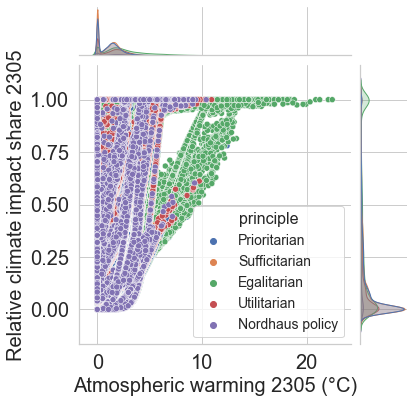

C:\Users\ivart\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


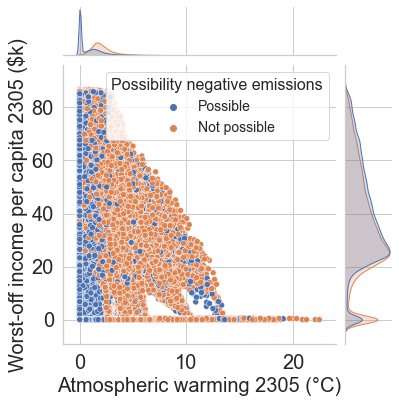

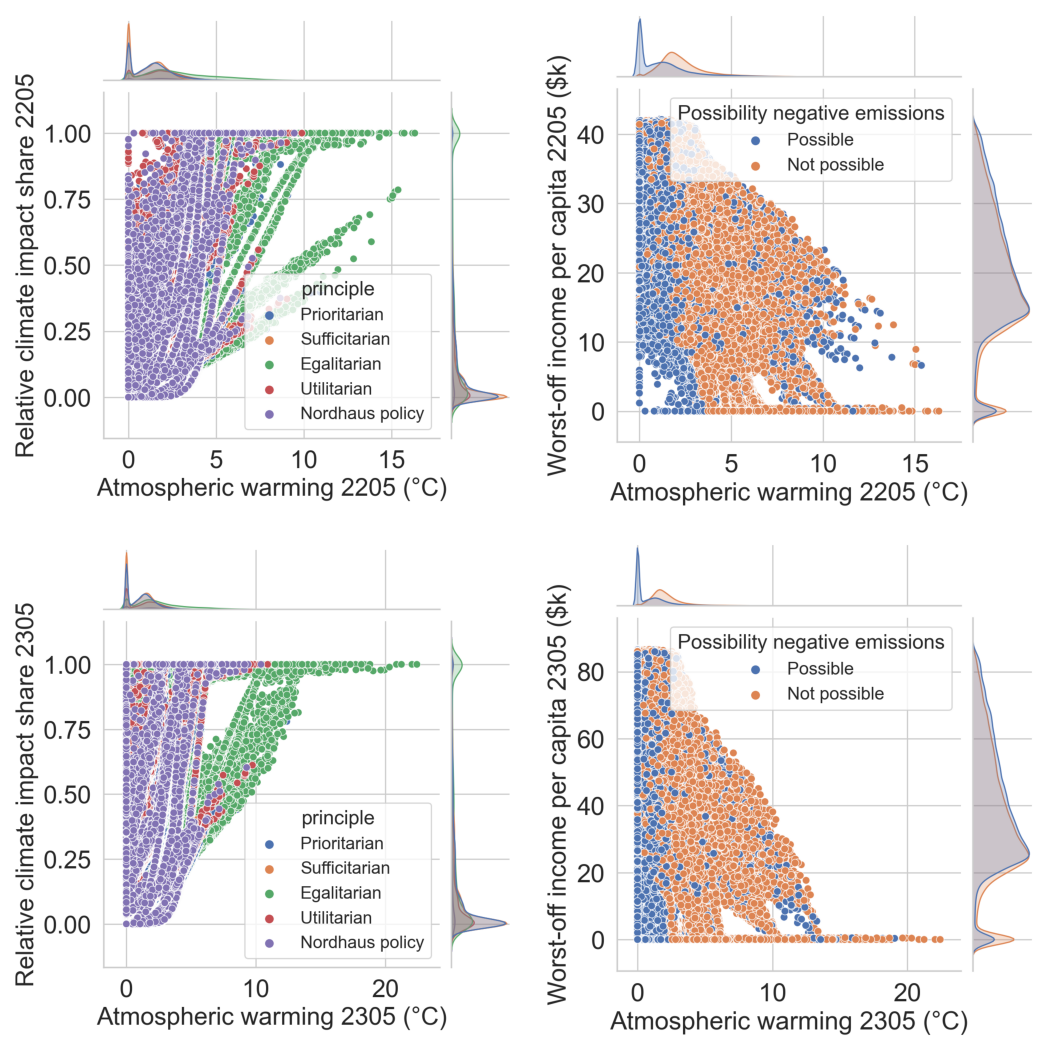

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#joint plot 1
g1 = sns.jointplot(height = 6,data=experiments_total, x='Atmospheric Temperature 2205', y="Highest climate impact per capita 2205", hue="principle")
g2 = sns.jointplot(height = 6,data=experiments_total, x='Atmospheric Temperature 2205', y="Lowest income per capita 2205", hue="Possibility negative emissions")

#joint plot 2
g3 = sns.jointplot(height = 6,data=experiments_total, x='Atmospheric Temperature 2305', y="Highest climate impact per capita 2305", hue="principle")
g4 = sns.jointplot(height = 6,data=experiments_total, x='Atmospheric Temperature 2305', y="Lowest income per capita 2305", hue="Possibility negative emissions")

g1.set_axis_labels('Atmospheric warming 2205 (°C)', 'Relative climate impact share 2205')
g2.set_axis_labels('Atmospheric warming 2205 (°C)', 'Worst-off income per capita 2205 ($k)')
g3.set_axis_labels('Atmospheric warming 2305 (°C)', 'Relative climate impact share 2305')
g4.set_axis_labels('Atmospheric warming 2305 (°C)', 'Worst-off income per capita 2305 ($k)')

############### 2. SAVE PLOTS IN MEMORY TEMPORALLY
g1.savefig('g1.png',dpi = 200)
plt.close(g1.fig)

g2.savefig('g2.png',dpi = 200)
plt.close(g2.fig)

g3.savefig('g3.png',dpi = 200)
plt.close(g2.fig)

g4.savefig('g4.png',dpi = 200)
plt.close(g2.fig)

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(2, 2, figsize=(15, 15))

axarr[0,0].imshow(mpimg.imread('g1.png'))
axarr[0,1].imshow(mpimg.imread('g2.png'))
axarr[1,0].imshow(mpimg.imread('g3.png'))
axarr[1,1].imshow(mpimg.imread('g4.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("quatrojointplot_long_term_uncertainty_prioritarian_objectives.png", dpi=200)

C:\Users\ivart\anaconda3\lib\site-packages\seaborn\axisgrid.py:1774: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(*args, **kwargs)
C:\Users\ivart\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


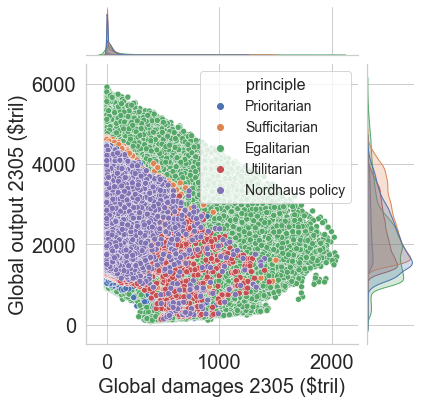

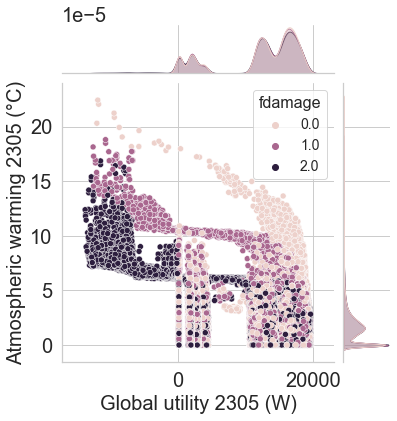

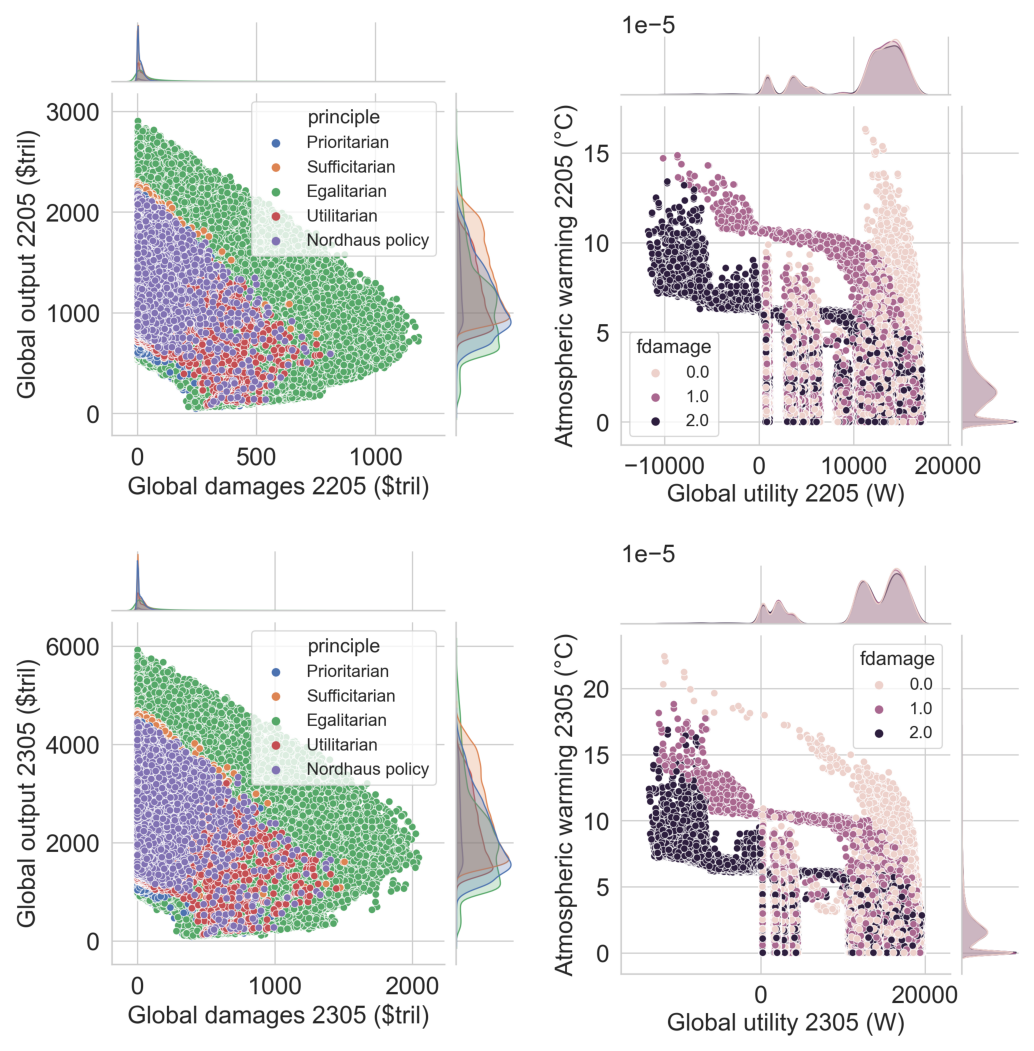

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#joint plot 1
g1 = sns.jointplot(height = 6,data=experiments_total, x='Damages 2205', y="Total Output 2205", hue="principle")
g2 = sns.jointplot(height = 6,data=experiments_total, x='Utility 2205', y="Atmospheric Temperature 2205", hue="fdamage")

#joint plot 2
g3 = sns.jointplot(height = 6,data=experiments_total, x='Damages 2305', y="Total Output 2305", hue="principle")
g4 = sns.jointplot(height = 6,data=experiments_total, x='Utility 2305', y="Atmospheric Temperature 2305", hue="fdamage")

g1.set_axis_labels('Global damages 2205 ($tril)', 'Global output 2205 ($tril)')
g2.set_axis_labels('Global utility 2205 (W)', 'Atmospheric warming 2205 (°C)')
g3.set_axis_labels('Global damages 2305 ($tril)', 'Global output 2305 ($tril)')
g4.set_axis_labels('Global utility 2305 (W)','Atmospheric warming 2305 (°C)')

############### 2. SAVE PLOTS IN MEMORY TEMPORALLY
g1.savefig('g1.png',dpi = 200)
plt.close(g1.fig)

g2.savefig('g2.png',dpi = 200)
plt.close(g2.fig)

g3.savefig('g3.png',dpi = 200)
plt.close(g2.fig)

g4.savefig('g4.png',dpi = 200)
plt.close(g2.fig)

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(2, 2, figsize=(15, 15))

axarr[0,0].imshow(mpimg.imread('g1.png'))
axarr[0,1].imshow(mpimg.imread('g2.png'))
axarr[1,0].imshow(mpimg.imread('g3.png'))
axarr[1,1].imshow(mpimg.imread('g4.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("quatrojointplot_long_term_uncertainty_utilitarian_objectives.png", dpi=200)

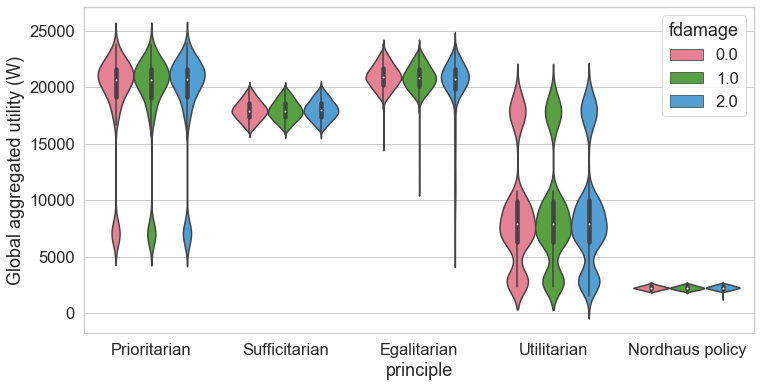

In [13]:
sns.set(font_scale=1.5)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Total Aggregated Utility', hue="fdamage",
                    data=experiments_total, palette="husl",bw = 0.2,  cut=2)
ax.set(ylabel='Global aggregated utility (W)')

fig.savefig("violin_plot_aggregated_utility_damage_function.png",dpi=200)

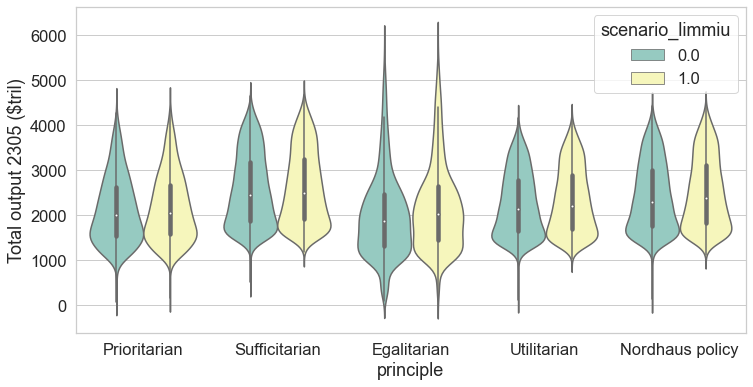

In [14]:
sns.set(font_scale=1.5)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Total Output 2305', hue="scenario_limmiu",
                    data=experiments_total, palette="Set3",bw = 0.2,  cut=2)
ax.set(ylabel='Total output 2305 ($tril)')

fig.savefig("violin_plot_total_output_negative_emissions.png",dpi=200)

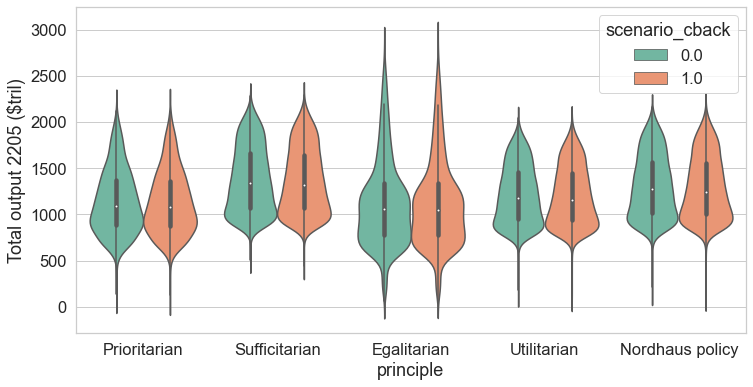

In [15]:
sns.set(font_scale=1.5)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Total Output 2205', hue="scenario_cback",
                    data=experiments_total, palette="Set2",bw = 0.2,  cut=2)
ax.set(ylabel='Total output 2205 ($tril)')

fig.savefig("violin_plot_total_output_cost_backstop.png",dpi=200)

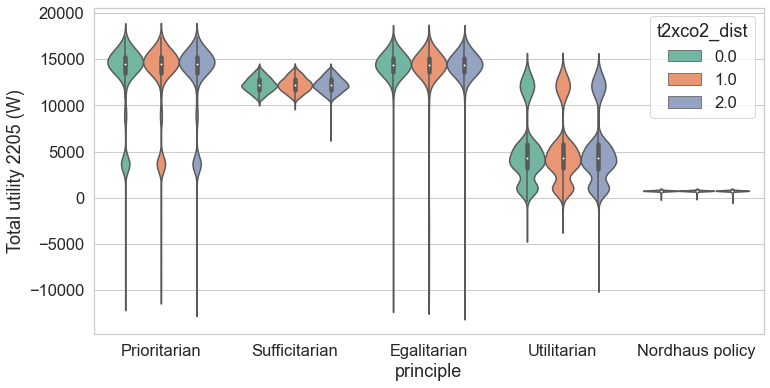

In [16]:
sns.set(font_scale=1.5)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Utility 2205', hue="t2xco2_dist",
                    data=experiments_total, palette="Set2",bw = 0.2,  cut=2)
ax.set(ylabel='Total utility 2205 (W)')

fig.savefig("violin_plot_utility_temperature_dist.png",dpi=200)

# Egalitarian objective analysis - distribution plots

C:\Users\ivart\anaconda3\lib\site-packages\seaborn\axisgrid.py:1774: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(*args, **kwargs)


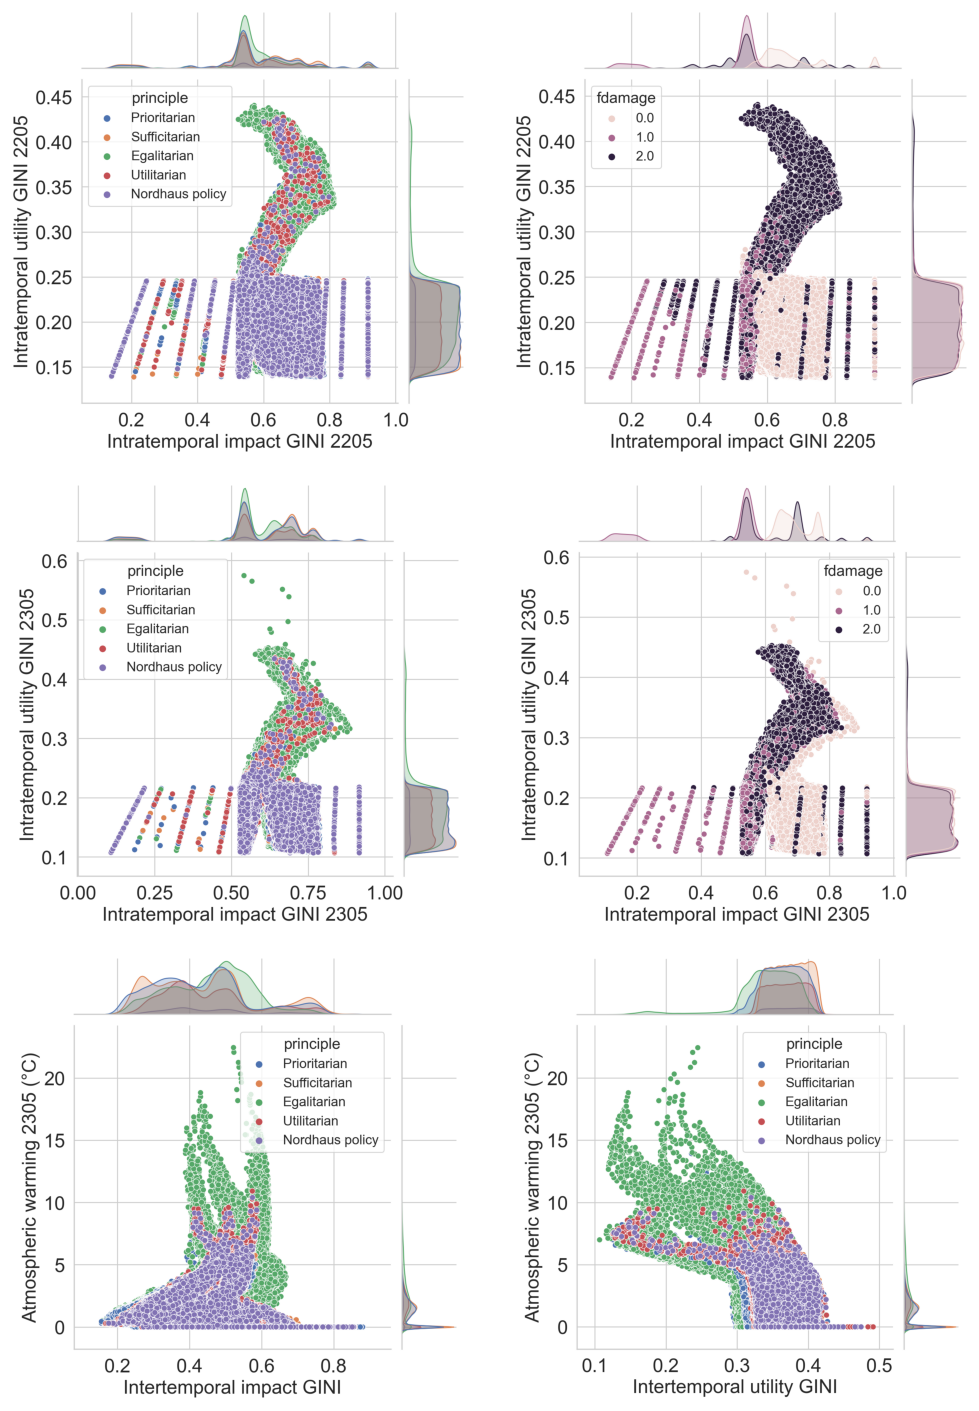

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc=rc1)
sns.set_style("whitegrid")

#joint plot 1
g1 = sns.jointplot(height = 7,data=experiments_total, x='Intratemporal impact GINI 2205', y="Intratemporal utility GINI 2205", hue="principle")
g2 = sns.jointplot(height = 7,data=experiments_total, x='Intratemporal impact GINI 2205', y="Intratemporal utility GINI 2205", hue="fdamage")

#joint plot 2
g3 = sns.jointplot(height = 7,data=experiments_total, x='Intratemporal impact GINI 2305', y="Intratemporal utility GINI 2305", hue="principle")
g4 = sns.jointplot(height = 7,data=experiments_total, x='Intratemporal impact GINI 2305', y="Intratemporal utility GINI 2305", hue="fdamage")

#joint plot 3
g5 = sns.jointplot(height = 7,data=experiments_total, x='Intertemporal impact GINI', y="Atmospheric Temperature 2305", hue="principle")
g6 = sns.jointplot(height = 7,data=experiments_total, x='Intertemporal utility GINI', y="Atmospheric Temperature 2305", hue="principle")

g5.set_axis_labels('Intertemporal impact GINI', 'Atmospheric warming 2305 (°C)')
g6.set_axis_labels('Intertemporal utility GINI','Atmospheric warming 2305 (°C)')

############### 2. SAVE PLOTS IN MEMORY TEMPORALLY
g1.savefig('g1.png',dpi = 200)
plt.close(g1.fig)

g2.savefig('g2.png',dpi = 200)
plt.close(g2.fig)

g3.savefig('g3.png',dpi = 200)
plt.close(g3.fig)

g4.savefig('g4.png',dpi = 200)
plt.close(g4.fig)

g5.savefig('g5.png',dpi = 200)
plt.close(g5.fig)

g6.savefig('g6.png',dpi = 200)
plt.close(g6.fig)

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(3, 2, figsize=(15, 20))

axarr[0,0].imshow(mpimg.imread('g1.png'))
axarr[0,1].imshow(mpimg.imread('g2.png'))
axarr[1,0].imshow(mpimg.imread('g3.png'))
axarr[1,1].imshow(mpimg.imread('g4.png'))
axarr[2,0].imshow(mpimg.imread('g5.png'))
axarr[2,1].imshow(mpimg.imread('g6.png'))
# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("sixjointplot_long_term_uncertainty_egalitarian_objectives.png", dpi=200)

# Sufficitarian objective analysis - distribution plots

C:\Users\ivart\anaconda3\lib\site-packages\seaborn\axisgrid.py:1774: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(*args, **kwargs)


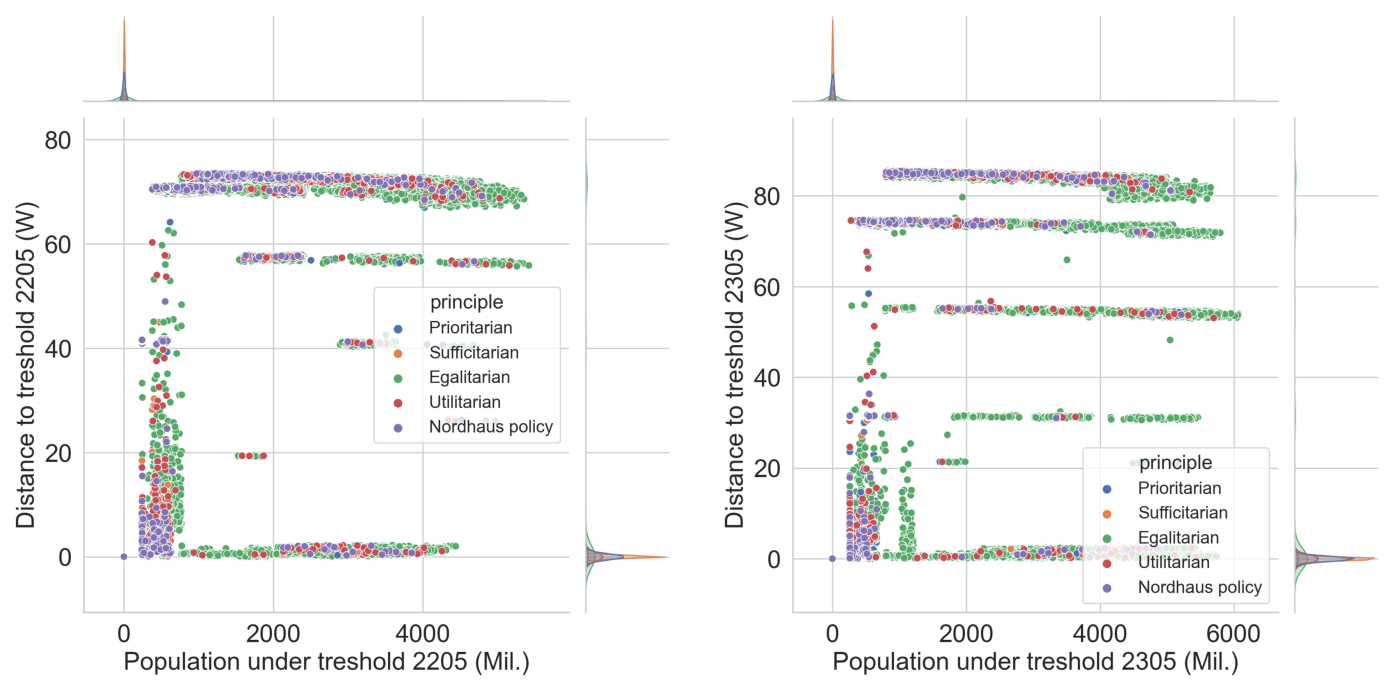

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc=rc1)
sns.set_style("whitegrid")

#joint plot 1
g1 = sns.jointplot(height = 8,data=experiments_total, x='Population under treshold 2205', y="Distance to treshold 2205", 
                   hue="principle")

g2 = sns.jointplot(height = 8,data=experiments_total, x='Population under treshold 2305', y="Distance to treshold 2305", 
                   hue="principle")

g1.set_axis_labels('Population under treshold 2205 (Mil.)', 'Distance to treshold 2205 (W)')
g2.set_axis_labels('Population under treshold 2305 (Mil.)', 'Distance to treshold 2305 (W)')

############### 2. SAVE PLOTS IN MEMORY TEMPORALLY
g1.savefig('g1.png',dpi = 200)
plt.close(g1.fig)

g2.savefig('g2.png',dpi = 200)
plt.close(g2.fig)

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(mpimg.imread('g1.png'))
axarr[1].imshow(mpimg.imread('g2.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("dualjointplot_long_term_uncertainty_sufficitarian_objectives.png", dpi=200)

# Prioritarian objective analysis - distribution plots

 Higher fat tail exposure for egalitarian and utilitarian principle even in long term scenario both at 2205 and 2305


C:\Users\ivart\anaconda3\lib\site-packages\seaborn\axisgrid.py:1774: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(*args, **kwargs)
C:\Users\ivart\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


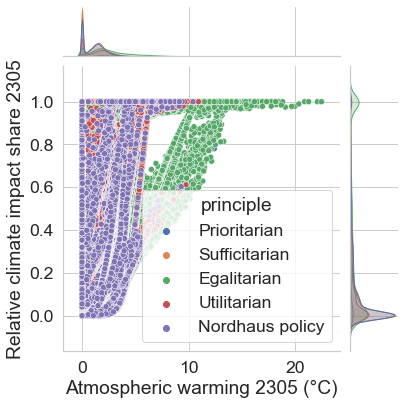

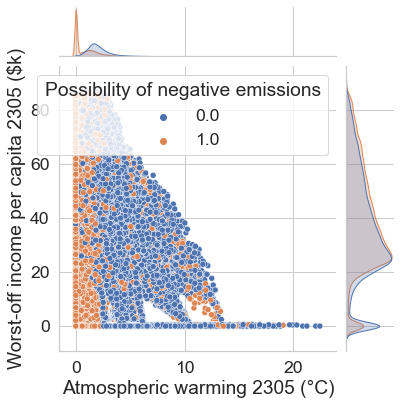

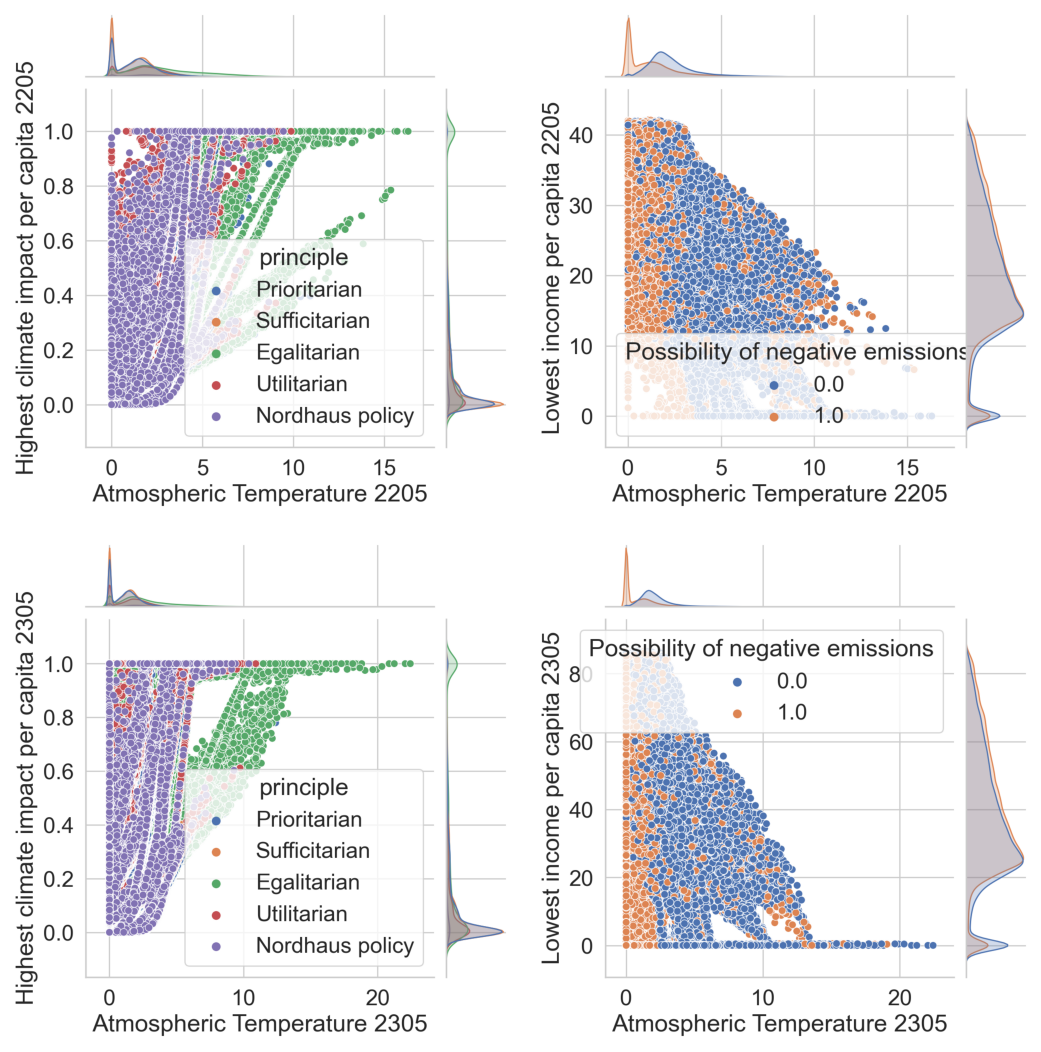

In [25]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
data = experiments_total[['Atmospheric Temperature 2205','Atmospheric Temperature 2305','Highest climate impact per capita 2205',
                          'Highest climate impact per capita 2305',"Lowest income per capita 2205","Lowest income per capita 2305",
                          "principle","scenario_limmiu"]]
data.columns = ['Atmospheric Temperature 2205','Atmospheric Temperature 2305','Highest climate impact per capita 2205',
                          'Highest climate impact per capita 2305',"Lowest income per capita 2205","Lowest income per capita 2305",
                          "principle","Possibility of negative emissions"]
mapping = {0:"Not possible",1: "possible"}
data = data.replace({"scenario_limmiu": mapping})

#joint plot 1
g1 = sns.jointplot(height = 6,data=data, x='Atmospheric Temperature 2205', y="Highest climate impact per capita 2205", hue="principle")
g2 = sns.jointplot(height = 6,data=data, x='Atmospheric Temperature 2205', y="Lowest income per capita 2205", hue="Possibility of negative emissions")

#joint plot 2
g3 = sns.jointplot(height = 6,data=data, x='Atmospheric Temperature 2305', y="Highest climate impact per capita 2305", hue="principle")
g4 = sns.jointplot(height = 6,data=data, x='Atmospheric Temperature 2305', y="Lowest income per capita 2305", hue="Possibility of negative emissions")

############### 2. SAVE PLOTS IN MEMORY TEMPORALLY
g1.savefig('g1.png',dpi = 200)
plt.close(g1.fig)

g2.savefig('g2.png',dpi = 200)
plt.close(g2.fig)

g3.savefig('g3.png',dpi = 200)
plt.close(g2.fig)

g4.savefig('g4.png',dpi = 200)
plt.close(g2.fig)

g1.set_axis_labels('Atmospheric warming 2205 (°C)', 'Relative climate impact share 2205')
g2.set_axis_labels('Atmospheric warming 2205 (°C)', 'Worst-off income per capita 2205 ($k)')
g3.set_axis_labels('Atmospheric warming 2305 (°C)', 'Relative climate impact share 2305')
g4.set_axis_labels('Atmospheric warming 2305 (°C)', 'Worst-off income per capita 2305 ($k)')

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(2, 2, figsize=(15, 15))

axarr[0,0].imshow(mpimg.imread('g1.png'))
axarr[0,1].imshow(mpimg.imread('g2.png'))
axarr[1,0].imshow(mpimg.imread('g3.png'))
axarr[1,1].imshow(mpimg.imread('g4.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("quatrojointplot_long_term_uncertainty_prioritarian_objectives.png", dpi=200)

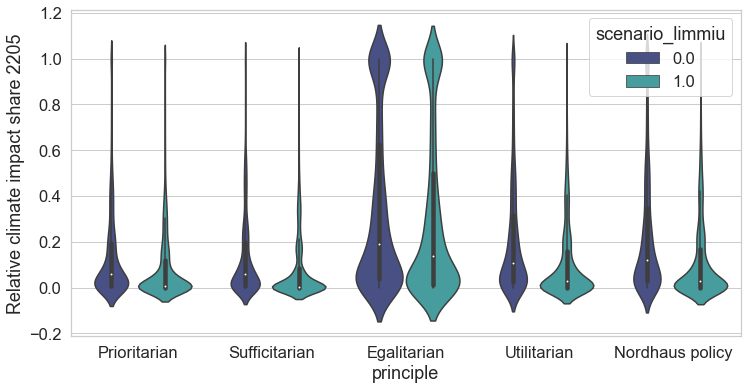

In [19]:
sns.set(font_scale=1.5)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Highest climate impact per capita 2205', hue="scenario_limmiu",
                    data=experiments_total, palette="mako",bw = 0.2,  cut=2)
ax.set(ylabel='Relative climate impact share 2205')

fig.savefig("violin_plot_relative_climate_impact_limmiu.png",dpi=200)

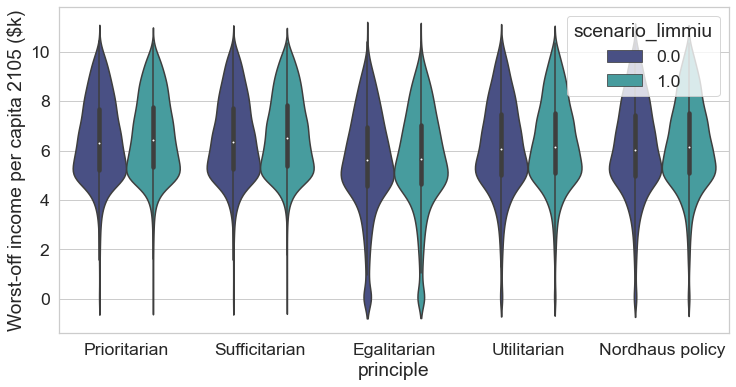

In [20]:
sns.set(font_scale=1.6)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Lowest income per capita 2105', hue="scenario_limmiu",
                    data=experiments_total, palette="mako",bw = 0.2,  cut=2)
ax.set(ylabel='Worst-off income per capita 2105 ($k)')

fig.savefig("violin_plot_worst_off_limmiu2105.png",dpi=200)

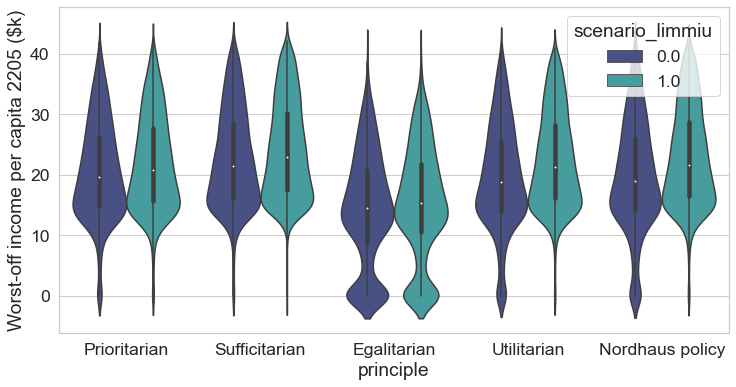

In [21]:
sns.set(font_scale=1.6)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Lowest income per capita 2205', hue="scenario_limmiu",
                    data=experiments_total, palette="mako",bw = 0.2,  cut=2)
ax.set(ylabel='Worst-off income per capita 2205 ($k)')

fig.savefig("violin_plot_worst_off_limmiu2205.png",dpi=200)

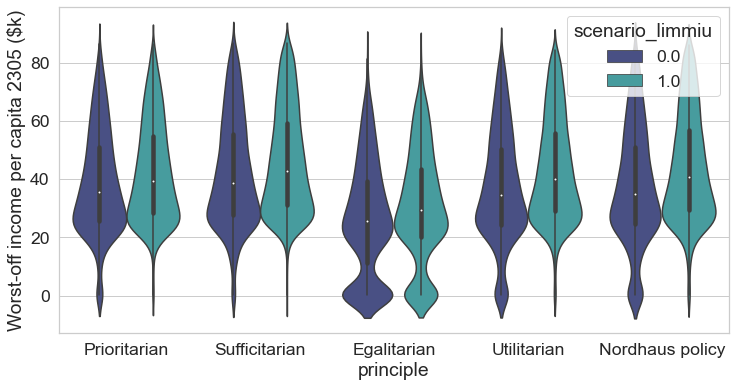

In [22]:
sns.set(font_scale=1.6)  # crazy big
sns.set_style("whitegrid")

a4_dims = (12,6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(ax=ax,x="principle", y='Lowest income per capita 2305', hue="scenario_limmiu",
                    data=experiments_total, palette="mako",bw = 0.2,  cut=2)
ax.set(ylabel='Worst-off income per capita 2305 ($k)')

fig.savefig("violin_plot_worst_off_limmiu2305.png",dpi=200)

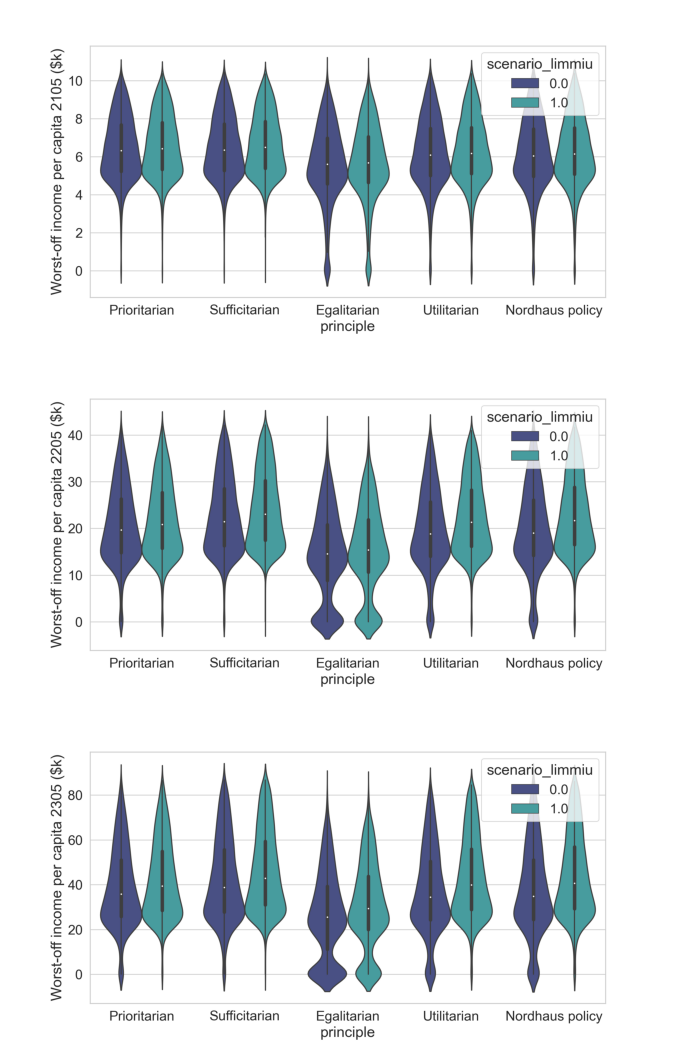

In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(3, 1, figsize=(15, 15))

axarr[0].imshow(mpimg.imread('violin_plot_worst_off_limmiu2105.png'))
axarr[1].imshow(mpimg.imread('violin_plot_worst_off_limmiu2205.png'))
axarr[2].imshow(mpimg.imread('violin_plot_worst_off_limmiu2305.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("violin_plot_worst_off_limmiu2105-2305.png", dpi=200)